NODE CLASSIFICATION
--------------------

Predict the category of a paper given:
- Binary indicators that it mentions a certain set of words
- Identificators of the papers it mentions

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

Loads citations

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.head(5)

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


Loads paper feats

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
papers.head(5)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


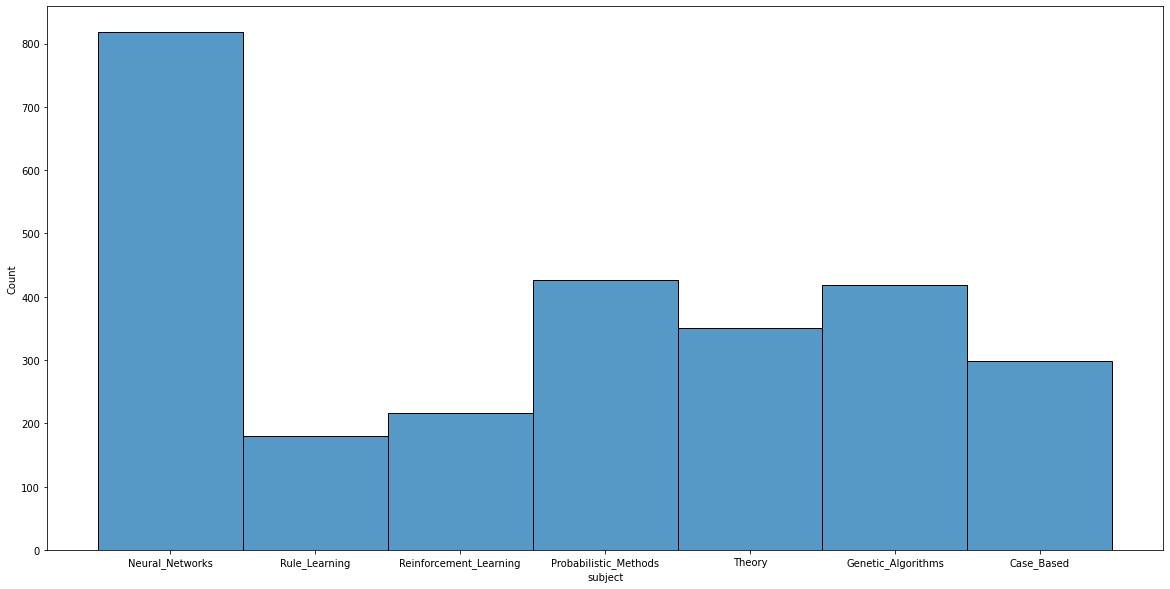

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(papers["subject"]);

In [ ]:
label_encoder_targets = LabelEncoder()
papers["subject"] = label_encoder_targets.fit_transform(papers["subject"])

label_encoder_papers = LabelEncoder()
papers["paper_id"] = label_encoder_papers.fit_transform(papers["paper_id"])

citations["source"] = label_encoder_papers.transform(citations["source"])
citations["target"] = label_encoder_papers.transform(citations["target"])


# Analysis

In [ ]:
n_labels = len(label_encoder_targets.classes_)
feature_names = [f for f in papers.columns if "term_" in f]
n_nodes = len(papers)

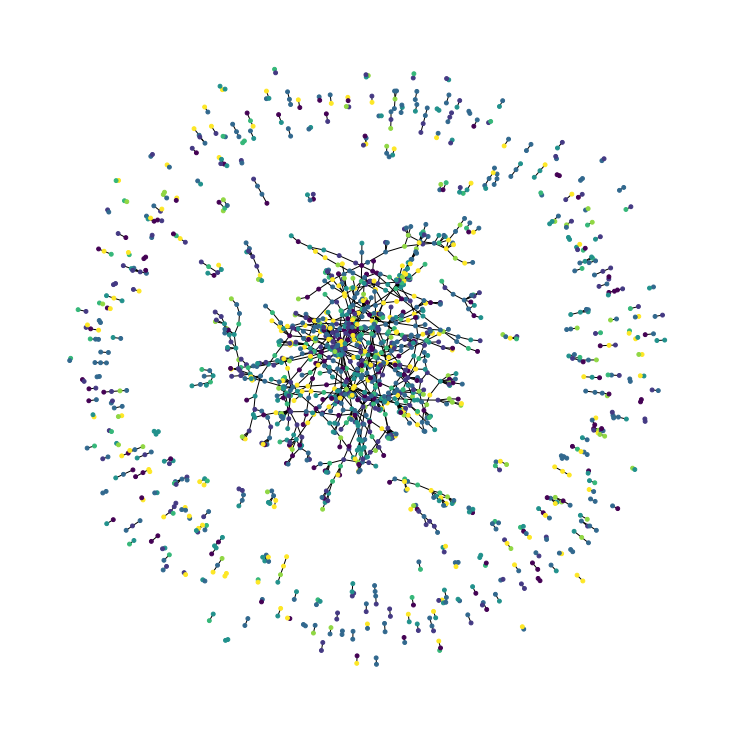

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [ ]:
from scipy.sparse import coo_matrix
all_edges = np.concatenate([citations, citations], axis=0)
adjacency_matrix = coo_matrix((np.ones(len(all_edges)), (all_edges[:,0], all_edges[:, 1])), dtype=np.int8,
                              shape=(n_nodes, n_nodes))

laplacian = adjacency_matrix.copy()
diag = - np.asarray(laplacian.sum(axis=0)[0].tolist())[0]
laplacian.setdiag(diag)

In [ ]:
values, _ = np.linalg.eig(laplacian.toarray())

In [ ]:
len([v for v in values if v == 0])

486

# Data Preparation

Split into train and test

In [ ]:
papers_train, papers_test = train_test_split(papers["paper_id"], stratify=papers["subject"])

In [ ]:
print("Samples in training: ", len(papers_train))
print("Samples in test: ", len(papers_test))

Samples in training:  2031
Samples in test:  677


# Baseline models (no graphs)

Predictions only based on the words presence

In [ ]:
dict_results = {}

In [ ]:
data_train = papers.merge(papers_train, on="paper_id", how="inner")
data_test = papers.merge(papers_test, on="paper_id", how="inner")

In [ ]:
X_train = data_train.drop(columns=["paper_id", "subject"])
X_test = data_test.drop(columns=["paper_id", "subject"])
y_train = data_train["subject"]
y_test = data_test["subject"]

## Logistic Regression

In [ ]:
lr = LogisticRegression().fit(X_train, y_train)
score =  lr.score(X_test, y_test)
dict_results["linear baseline"] = score
print("Accuracy linear model: ", score)

Accuracy linear model:  0.7518463810930576


## Random forest

In [ ]:
rf = RandomForestClassifier().fit(X_train, y_train)

score = rf.score(X_test, y_test)
dict_results["random forest"] = score
print("Accuracy random forest model: ", score)

Accuracy random forest model:  0.7621861152141802


## Neural Network

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def create_fnn_layer():
  layers_nn = []
  for units in hidden_units:
      layers_nn.append(layers.BatchNormalization())
      layers_nn.append(layers.Dropout(dropout_rate))
      layers_nn.append(layers.Dense(units, activation=tf.nn.gelu))

  fnn_layer = keras.models.Sequential(layers_nn)
  return fnn_layer


inputs = layers.Input(shape=(X_train.shape[1],), name="input_features")
x = create_fnn_layer()(inputs)
for block_idx in range(4):
    # Create an FFN block.
    x1 = create_fnn_layer()(x)
    # Add skip connection.
    x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])

# Compute logits.
logits = layers.Dense(n_labels, name="logits")(x)

nn_model = keras.models.Model(inputs, x)

# Compile the model.
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=50, restore_best_weights=True
)
nn_model.summary()
# Fit the model.
history = nn_model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=0
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 sequential_47 (Sequential)     (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 sequential_48 (Sequential)     (None, 32)           2368        ['sequential_47[0][0]']          
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['sequential_47[0][0]',          
                                                                  'sequential_48[0][0]']    

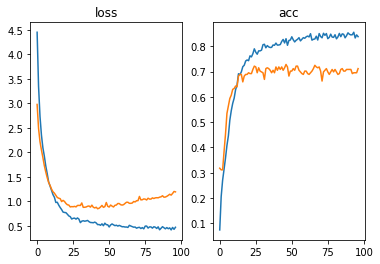

In [ ]:
metrics = [k for k in history.history.keys() if "val_" not in k]
fig, axs = plt.subplots(1, len(metrics))
for m, ax in zip(metrics, axs.flatten()):
  ax.plot(history.history[m])
  ax.plot(history.history["val_" + m])
  ax.set_title(m)

In [ ]:
score = nn_model.evaluate(X_test, y_test)[1]
dict_results["baseline neural network"] = score
print("Accuracy neural network model: ", score)

22/22 [==============================] - 0s 6ms/step - loss: 0.6832 - acc: 0.7710
Accuracy neural network model:  0.7710487246513367


# Graph Neural Network

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges_positive = citations[["source", "target"]].to_numpy().T
edges_negative = citations[["target", "source"]].to_numpy().T

edges = np.concatenate([edges_positive, edges_negative], axis=1)


# Create an edge weights array of ones.
edge_weights_positive = tf.ones(shape=edges_positive.shape[1])
edge_weights_negative = tf.zeros(shape=edges_negative.shape[1])

edges_types = np.concatenate([edge_weights_positive, edge_weights_negative], axis=0)


# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edges_types)

print("Edges positive shape:", edges_positive.shape)
print("Edges negative shape:", edges_negative.shape)
print("Edges shape:", edges.shape)

print("Edges type shape:", edges_types.shape)
print("Nodes shape:", node_features.shape)

Edges positive shape: (2, 5429)
Edges negative shape: (2, 5429)
Edges shape: (2, 10858)
Edges type shape: (10858,)
Nodes shape: (2708, 1433)


Steps:


- **Prepare**: The input node representations are processed using a FFN to produce a message. You can simplify the processing by only applying linear transformation to the representations.
- **Aggregate**: The messages of the neighbours of each node are aggregated with respect to the edge_weights using a permutation invariant pooling operation, such as sum, mean, and max, to prepare a single aggregated message for each node. See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages.
- **Update**: The node_repesentations and aggregated_messages—both of shape [num_nodes, representation_dim]— are combined and processed to produce the new state of the node representations (node embeddings). If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or concatenated, then processed using a FFN.

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_fnn_layer()

        self.type_edge_embedding = keras.layers.Embedding(input_dim=2,
                                                          output_dim=1)

        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_fnn_layer()

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            weights = weights if len(weights.shape) == 2 else tf.expand_dims(weights, -1)
            messages = messages * weights
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edges_types = inputs
        edge_weights = self.type_edge_embedding(edges_types)
        edge_weights = keras.layers.Flatten()(edge_weights)
        
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)
        
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_fnn_layer()
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_fnn_layer()
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=n_labels,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]).shape)

gnn_model.summary()

GNN output shape: (3, 7)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_41 (Sequential)  (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5890      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5890      
 )                                                               
                                                                 
 sequential_46 (Sequential)  (2708, 32)                2368      
                                                                 
 logits (Dense)              multiple                  231       
                                                                 
Total params: 67,183
Trainable p

In [ ]:
x_train = data_train.paper_id.to_numpy()



# Compile the model.
gnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=50, restore_best_weights=True
)
gnn_model.summary()
# Fit the model.
history = gnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)


Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_41 (Sequential)  (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5890      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5890      
 )                                                               
                                                                 
 sequential_46 (Sequential)  (2708, 32)                2368      
                                                                 
 logits (Dense)              multiple                  231       
                                                                 
Total params: 67,183
Trainable params: 63,485
Non-trainab

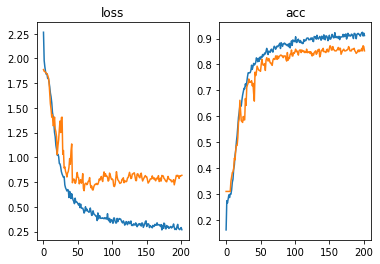

In [ ]:
metrics = [k for k in history.history.keys() if "val_" not in k]
fig, axs = plt.subplots(1, len(metrics))
for m, ax in zip(metrics, axs.flatten()):
  ax.plot(history.history[m])
  ax.plot(history.history["val_" + m])
  ax.set_title(m)

In [ ]:
x_test = data_test.paper_id.to_numpy()

score = gnn_model.evaluate(x_test, y_test)[1]
dict_results["graph neural network"] = score
print("Accuracy graph network model: ", score)

22/22 [==============================] - 1s 58ms/step - loss: 0.5588 - acc: 0.8582
Accuracy graph network model:  0.8581979274749756


# Results

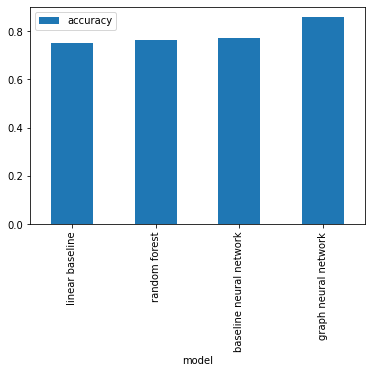

In [ ]:
pd.DataFrame(dict_results.items(), columns=["model", "accuracy"]).set_index("model").plot.bar()